# 1. Carga de bibliotecas
Seccion para instalar e importar bibliotecas necesarias

In [ ]:
!pip install numpy==1.25.2 fitter==1.7.1
!pip install thinc --upgrade

# Importar dependencias
from fitter import Fitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random
from datetime import datetime, timedelta

# 2. Generación de Datos Simulados

In [3]:
# Importar random, numpy y pandas aquí para asegurar su disponibilidad
import random
import numpy as np
import pandas as pd

# Parámetros de simulación
N_EVENTOS = 1000
GAS = 50
VALOR_TOKEN_MEDIA = 1000
VALOR_TOKEN_SD = 200

# Probabilidades de eventos secundarios
P_BURN = 0.05
P_UPDATE = 0.1

# Variables de estado
partes_de_prop = 1000
tokens_vend = []
saldo_vend = 5000

# Funciones auxiliares
def generar_TS():
    return np.random.exponential(scale=5)  # intervalo tokenización

def generar_LLIN():
    return np.random.lognormal(mean=2.5, sigma=0.5)  # intervalo llegada interesados

def generar_saldo_comprador():
    return np.random.randint(500, 5000)

def generar_valor_token():
    return max(10, int(np.random.normal(VALOR_TOKEN_MEDIA, VALOR_TOKEN_SD)))

# Inicializar
eventos = []
tiempo = 0
CTS = 0
CTF = 0
tokens_emitidos = 0
tokens_burneados = 0
saldos_compradores = []

# Simulación
for i in range(N_EVENTOS):
    r = random.random()

    if r < 0.35:
        # Evento TTS (tokenización solicitada)
        TS = generar_TS()
        tiempo += TS
        if partes_de_prop > len(tokens_vend):
            # Evento TM (mint)
            if saldo_vend >= GAS:
                CTS += 1
                saldo_vend -= GAS
                token_id = f"T{tokens_emitidos}"
                tokens_vend.append({"id": token_id, "precio": generar_valor_token()})
                tokens_emitidos += 1
                eventos.append([tiempo, "mint", token_id, saldo_vend, None])

    elif r < 0.7:
        # Evento TLLI (llegada_interesado)
        LLIN = generar_LLIN()
        tiempo += LLIN
        kyc_interesado = random.choice([True, False])
        if kyc_interesado:
            saldo_comprador = generar_saldo_comprador()
            if len(tokens_vend) > 0:
                token = random.choice(tokens_vend)
                precio = token["precio"]
                # Evento TCI (compra_interesado)
                if saldo_comprador >= precio:
                    saldo_comprador -= precio
                    saldo_vend += precio
                    tokens_vend.remove(token)
                    saldos_compradores.append(saldo_comprador)
                    eventos.append([tiempo, "compra_exitosa", token["id"], saldo_vend, saldo_comprador])
                else:
                    CTF += 1
                    eventos.append([tiempo, "compra_fallida_fondos", token["id"], saldo_vend, saldo_comprador])
            else:
                CTF += 1
                eventos.append([tiempo, "compra_fallida_sin_tokens", None, saldo_vend, None])

    else:
        # Eventos secundarios
        tiempo += np.random.exponential(scale=3)
        if len(tokens_vend) > 0:
            token = random.choice(tokens_vend)
            if random.random() < P_BURN:
                # Evento TBT (burn_token)
                tokens_vend.remove(token)
                tokens_burneados += 1
                eventos.append([tiempo, "burn_token", token["id"], saldo_vend, None])
            elif random.random() < P_UPDATE:
                # Evento TAP (actualización_precio)
                nuevo_precio = generar_valor_token()
                token["precio"] = nuevo_precio
                eventos.append([tiempo, "actualizacion_precio", token["id"], saldo_vend, nuevo_precio])

# Convertir a DataFrame
df_eventos = pd.DataFrame(eventos, columns=["tiempo", "evento", "token", "saldo_vendedor", "extra"])

# 3. Análisis Exploratorio de Datos

Primeras filas del dataset simulado:
      tiempo                     evento token  saldo_vendedor   extra
0  12.219646  compra_fallida_sin_tokens  None            5000     NaN
1  14.176187                       mint    T0            4950     NaN
2  35.363006             compra_exitosa    T0            5742  1189.0
3  53.081586  compra_fallida_sin_tokens  None            5742     NaN
4  55.734605                       mint    T1            5692     NaN

Eventos únicos simulados:
evento
mint                         340
compra_exitosa               139
actualizacion_precio          21
compra_fallida_fondos         15
burn_token                    12
compra_fallida_sin_tokens      2
Name: count, dtype: int64


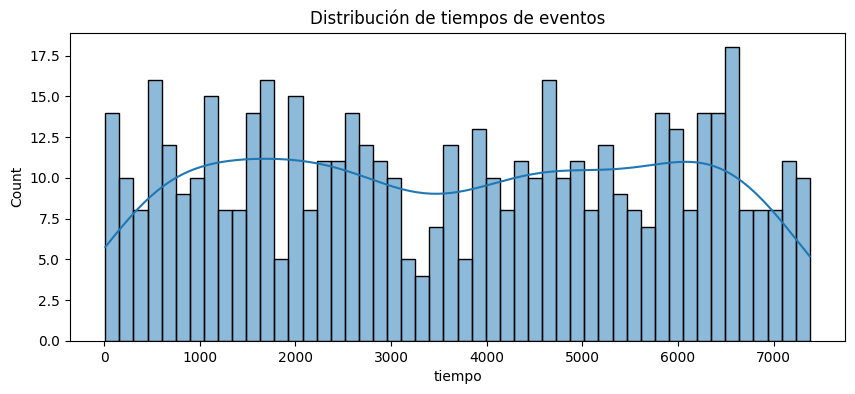

In [4]:
print("Primeras filas del dataset simulado:")
print(df_eventos.head())

print("\nEventos únicos simulados:")
print(df_eventos['evento'].value_counts())

# Histograma de tiempos
plt.figure(figsize=(10,4))
sns.histplot(df_eventos['tiempo'], bins=50, kde=True)
plt.title("Distribución de tiempos de eventos")
plt.show()

# 4. Ajuste de FDPs (TS y LLIN)


Promedio intervalo entre tokenizaciones: 21.65606671180508
Promedio intervalo entre llegadas de interesados: 47.52539109278663

Mejores ajustes TS:
{'gamma': {'a': np.float64(0.781474234251972), 'loc': np.float64(0.06843107470513131), 'scale': np.float64(26.724997915492004)}}

Mejores ajustes LLIN:
{'expon': {'loc': 5.4463702264420135, 'scale': 42.079020866344614}}


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.001055,1331.806607,1337.893458,inf,0.034552,0.989576
gamma,0.001083,1329.634220,1338.764496,inf,0.040373,0.953372
lognorm,0.001108,1326.135708,1335.265983,inf,0.056617,0.681516
norm,0.002500,1573.730313,1579.817163,inf,0.159323,0.000665


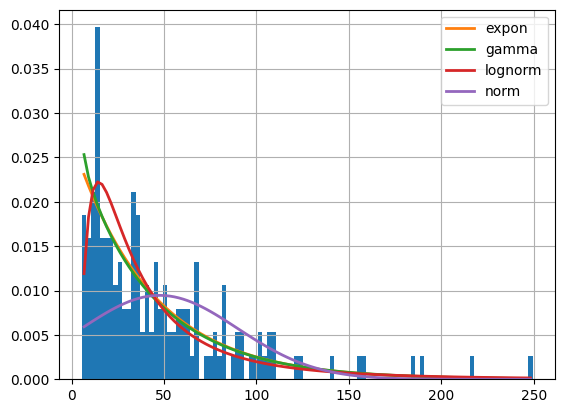

In [5]:
tiempos_token = df_eventos[df_eventos['evento']=="mint"]['tiempo'].diff().dropna()
tiempos_llin = df_eventos[df_eventos['evento'].str.contains("compra")]['tiempo'].diff().dropna()

print("\nPromedio intervalo entre tokenizaciones:", tiempos_token.mean())
print("Promedio intervalo entre llegadas de interesados:", tiempos_llin.mean())

# Ajuste TS
f_ts = Fitter(tiempos_token, distributions=['expon','gamma','lognorm','norm'])
f_ts.fit()
print("\nMejores ajustes TS:")
print(f_ts.get_best(method='sumsquare_error'))
f_ts.summary(5)

# Ajuste LLIN
f_llin = Fitter(tiempos_llin, distributions=['expon','gamma','lognorm','norm'])
f_llin.fit()
print("\nMejores ajustes LLIN:")
print(f_llin.get_best(method='sumsquare_error'))
f_llin.summary(5)

# 5. Variables de Resultados

In [6]:
CTS_final = CTS
PTB_final = tokens_burneados / tokens_emitidos if tokens_emitidos > 0 else 0
PSC_final = np.mean(saldos_compradores) if len(saldos_compradores)>0 else 0
CTF_final = CTF

print("\n=== RESULTADOS ===")
print("CTS (Cantidad total de tokenizaciones solicitadas):", CTS_final)
print("PTB (Porcentaje de tokens burneados):", PTB_final)
print("PSC (Promedio de saldo compradores):", PSC_final)
print("CTF (Cantidad de transferencias fallidas):", CTF_final)


=== RESULTADOS ===
CTS (Cantidad total de tokenizaciones solicitadas): 340
PTB (Porcentaje de tokens burneados): 0.03529411764705882
PSC (Promedio de saldo compradores): 1871.2086330935251
CTF (Cantidad de transferencias fallidas): 17


# 6. Visualizaciones de Resultados

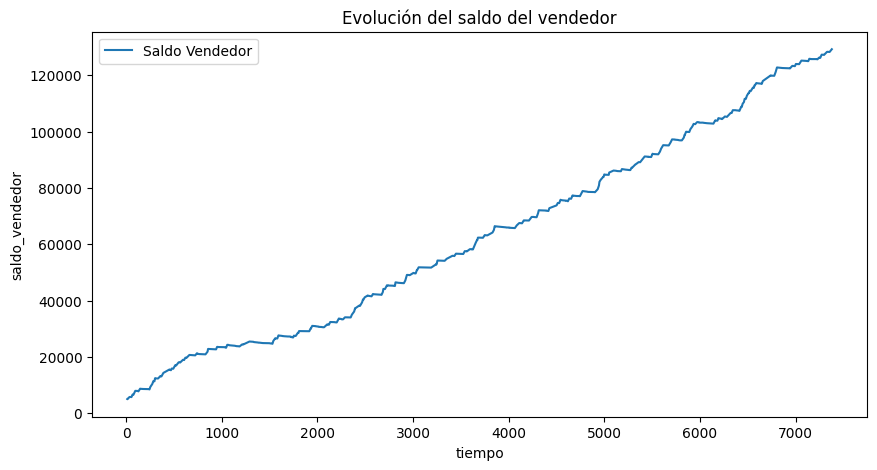

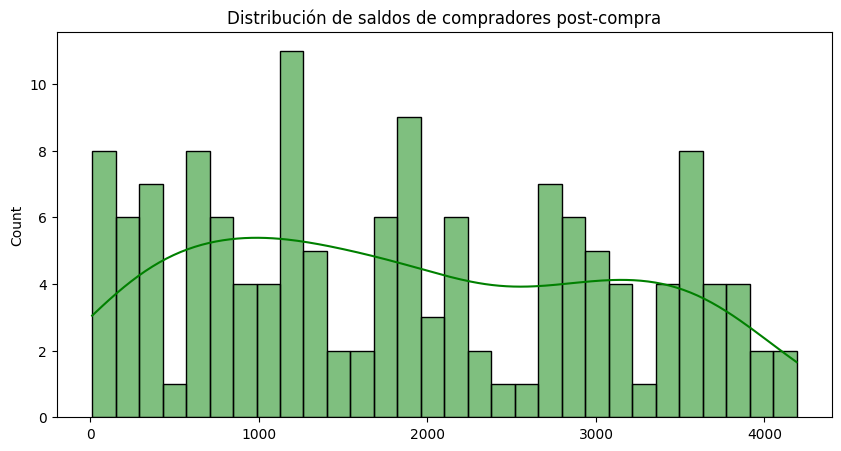

/tmp/ipython-input-1278524069.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resultados.keys()), y=list(resultados.values()), palette="viridis")


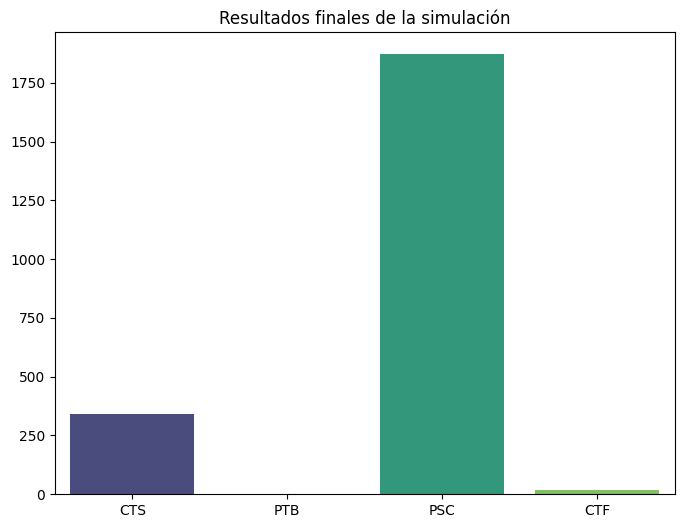

In [7]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_eventos, x="tiempo", y="saldo_vendedor", label="Saldo Vendedor")
plt.title("Evolución del saldo del vendedor")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(saldos_compradores, bins=30, kde=True, color="green")
plt.title("Distribución de saldos de compradores post-compra")
plt.show()

plt.figure(figsize=(8,6))
resultados = {"CTS":CTS_final, "PTB":PTB_final, "PSC":PSC_final, "CTF":CTF_final}
sns.barplot(x=list(resultados.keys()), y=list(resultados.values()), palette="viridis")
plt.title("Resultados finales de la simulación")
plt.show()